# Sentiment Analysis con KNN
## Clasificador en C++ 💪💪
Vamos a probar a nuestro bichito


Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

Correr la celda de abajo garantiza que los experimentos esten corriendo con la ultima versión release del programa.

In [1]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make -j install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.2.0
-- The CXX compiler identification is GNU 9.2.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Habilitando Log de Funciones de nivel 1
Release mode
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Found libomp without any special flags
-- Found PythonInterp: /home/j/Code/mn-tp2/.venv/bin/python (found version "3.7.4") 
-- Found PythonLibs: /us

In [2]:
%load_ext autoreload
%autoreload 2

# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import sentiment

# Resto de los imports
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import logging
from sklearn.metrics import accuracy_score

logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] %(message)s')
logger = logging.getLogger('notebook')
logger.setLevel(logging.DEBUG)

# Configuración de los plots de seaborn
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/j/Code/mn-tp2/notebooks
Python 3.7.4


In [6]:
def read_data(path='../data/imdb_small.csv'):
    '''
    Carga el dataset en memoria.
    '''

    logger.debug('Cargando datos en memoria.')

    df = pd.read_csv(path, index_col=0)
    logger.info("Cantidad de documentos: {}".format(df.shape[0]))

    # Separa los textos en instancias de test y entrenamiento.
    text_train = df[df.type == 'train']["review"]
    label_train = df[df.type == 'train']["label"]
    text_test = df[df.type == 'test']["review"]
    label_test = df[df.type == 'test']["label"]
    logger.info("Cantidad de instancias de entrenamiento = {}".format(len(text_train)))
    logger.info("Cantidad de instancias de test = {}".format(len(text_test)))

    # Calculo el class balance
    logger.info("Class balance : {:.3f} pos {:.3f} neg".format(
        (label_train == 'pos').sum() / label_train.shape[0], 
        (label_train == 'neg').sum() / label_train.shape[0]
    ))

    # Vectorizo los datos
    vectorizer = CountVectorizer(max_df=0.90, min_df=0.01, max_features=5000)
    vectorizer.fit(text_train)
    X_train, y_train = vectorizer.transform(text_train), (label_train == 'pos').values
    X_test, y_test = vectorizer.transform(text_test), (label_test == 'pos').values
    logger.debug(f'X_train.shape = {X_train.shape}')
    logger.debug(f'y_train.shape = {y_train.shape}')
    logger.debug(f'X_test.shape = {X_test.shape}')
    logger.debug(f'y_test.shape = {y_test.shape}')

    return X_train, y_train, X_test, y_test

# ----------------------------------------------------------------------------

X_train, y_train, X_test, y_test = read_data()

[DEBUG] Cargando datos en memoria.
[INFO] Cantidad de documentos: 12500
[INFO] Cantidad de instancias de entrenamiento = 6225
[INFO] Cantidad de instancias de test = 6275
[INFO] Class balance : 0.495 pos 0.505 neg
[DEBUG] X_train.shape = (6225, 1820)
[DEBUG] y_train.shape = (6225,)
[DEBUG] X_test.shape = (6275, 1820)
[DEBUG] y_test.shape = (6275,)


## Búsqueda de $k$ óptimo

La idea es empezar a buscar en el rango $\left[ 1, \dots, 3000 \right]$, con una granularidad alta para luego hacer una exploración detallada en las zonas de mejor _accuracy_.

In [4]:
def lin_search(ks):
    '''
    Función para hacer una búsqueda lineal del accuracy para distintos valores
    de `k`.
    '''

    # Primero construye el kdtree. La idea es usar el mismo kdtree para luego
    # clasificar bajo distintos valores de k
    logger.debug('Construyendo el kdtree')
    time_fit_begin = time.perf_counter()
    clf = sentiment.KNNClassifier(42) # No importa el numero
    clf.fit(X_train, y_train)
    time_fit_end = time.perf_counter()
    time_fit = time_fit_end - time_fit_begin
    logger.debug(f'Se construyó el kdtree en {time_fit:.3f}s')
    
    mediciones = []
    for k in ks:

        logger.debug(f'Clasificando para k={k}...')

        time_predict_begin = time.perf_counter()
        clf.setNeightbors(k)
        y_pred = clf.predict(X_test)
        time_predict_end = time.perf_counter()
        time_predict = time_predict_end - time_predict_begin
 
        acc = accuracy_score(y_pred, y_test)
        logger.debug(f'Se clasificó para k={k} en {time_predict:.3f}s.')
        
        mediciones.append([k, acc, time_predict])
        
    df = pd.DataFrame(mediciones, columns=['k', 'acc', 'time_predict'])
    return df

### Primera exploración del espacio de hiperparámetros:

En una primera exploración se buscó aproximar el valor óptimo de $k$ en el espacio $1 \leq k \leq 3000$ con una granularidad muy alta, yendo de 100 en 100.

In [20]:
# Correr esta celda para buscar hiperparámetros
ks = list(range(1, 3000, 100))
df = lin_search(ks)

[DEBUG] Construyendo el kdtree
[DEBUG] Se construyó el kdtree en 0.725s
[DEBUG] Clasificando para k=1...
[DEBUG] Se clasificó para k=1 en 28.504s.
[DEBUG] Clasificando para k=101...
[DEBUG] Se clasificó para k=101 en 29.320s.
[DEBUG] Clasificando para k=201...
[DEBUG] Se clasificó para k=201 en 29.406s.
[DEBUG] Clasificando para k=301...
[DEBUG] Se clasificó para k=301 en 29.635s.
[DEBUG] Clasificando para k=401...
[DEBUG] Se clasificó para k=401 en 29.662s.
[DEBUG] Clasificando para k=501...
[DEBUG] Se clasificó para k=501 en 29.744s.
[DEBUG] Clasificando para k=601...
[DEBUG] Se clasificó para k=601 en 29.933s.
[DEBUG] Clasificando para k=701...
[DEBUG] Se clasificó para k=701 en 29.918s.
[DEBUG] Clasificando para k=801...
[DEBUG] Se clasificó para k=801 en 29.993s.
[DEBUG] Clasificando para k=901...
[DEBUG] Se clasificó para k=901 en 32.066s.
[DEBUG] Clasificando para k=1001...
[DEBUG] Se clasificó para k=1001 en 32.206s.
[DEBUG] Clasificando para k=1101...
[DEBUG] Se clasificó para

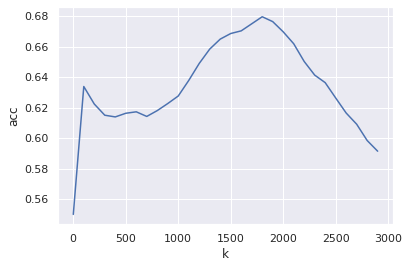

In [54]:
sns.lineplot(x='k', y='acc', data=df)

Se pueden ver dos máximos locales para los valores de $k$ explorados. Uno de mayor magnitud en el espacio $1500 \leq k \leq 2000$ y otro de menor magnitud en el rango $1 \leq k \leq 500$.

In [61]:
def get_subset(df, k_min, k_max):
    return df[k_min <= df['k']][df['k'] <= k_max]

def get_max_local(df, k_min, k_max):
    '''
    Devuelve el máximo local para el accuracy en el rango `min_k <= k <= max_k`.
    '''
    df_subset = get_subset(df, k_min, k_max)
    id_opt = df_subset['acc'].idxmax()
    return df_subset.loc[id_opt]

print(f'Optimo local 1:')
print(get_max_local(df, 0, 500))

print()

print(f'Optimo local 2:')
print(get_max_local(df, 1500, 2000))

Optimo local 1:
k               101.000000
acc               0.633785
time_predict     30.617797
Name: 1, dtype: float64

Optimo local 2:
k               1801.000000
acc                0.679522
time_predict      30.681591
Name: 18, dtype: float64


/home/j/Code/mn-tp2/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


El primer óptimo local eta en $k = 101$. El segundo en $k = 1801$

(1, 500)

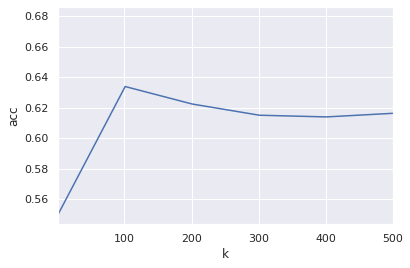

In [66]:
sns.lineplot(x='k', y='acc', data=df)
plt.xlim(1, 500)

(1500, 2000)

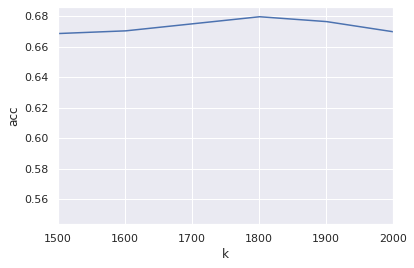

In [67]:
sns.lineplot(x='k', y='acc', data=df)
plt.xlim(1500, 2000)

### Mediciones para el optimo 1

Tomo mediciones con menor granularidad para los dos optimos locales encontrados. Pruebo el rango $\{1, 11, \dots, 191\}$.

In [7]:
df_opt_1 = lin_search(range(1, 200, 10))

[DEBUG] Construyendo el kdtree
[DEBUG] Se construyó el kdtree en 0.732s
[DEBUG] Clasificando para k=1...
[DEBUG] Se clasificó para k=1 en 28.714s.
[DEBUG] Clasificando para k=11...
[DEBUG] Se clasificó para k=11 en 29.096s.
[DEBUG] Clasificando para k=21...
[DEBUG] Se clasificó para k=21 en 29.105s.
[DEBUG] Clasificando para k=31...
[DEBUG] Se clasificó para k=31 en 29.229s.
[DEBUG] Clasificando para k=41...
[DEBUG] Se clasificó para k=41 en 29.174s.
[DEBUG] Clasificando para k=51...
[DEBUG] Se clasificó para k=51 en 29.206s.
[DEBUG] Clasificando para k=61...
[DEBUG] Se clasificó para k=61 en 29.283s.
[DEBUG] Clasificando para k=71...
[DEBUG] Se clasificó para k=71 en 29.327s.
[DEBUG] Clasificando para k=81...
[DEBUG] Se clasificó para k=81 en 29.262s.
[DEBUG] Clasificando para k=91...
[DEBUG] Se clasificó para k=91 en 29.452s.
[DEBUG] Clasificando para k=101...
[DEBUG] Se clasificó para k=101 en 29.292s.
[DEBUG] Clasificando para k=111...
[DEBUG] Se clasificó para k=111 en 29.490s.
[D

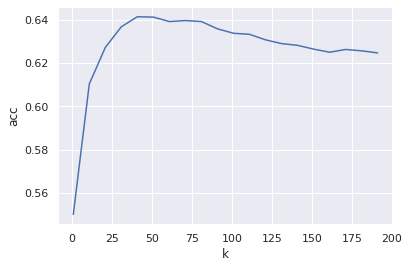

In [9]:
sns.lineplot(x='k', y='acc', data=df_opt_1)

### Mediciones para el optimo 2

Tomo mediciones con menor granularidad para los dos optimos locales encontrados. Pruebo el rango $\{1700, 1710, \dots, 1800\}$.

In [8]:
df_opt_2 = lin_search(range(1700, 1900, 10))

[DEBUG] Construyendo el kdtree
[DEBUG] Se construyó el kdtree en 0.720s
[DEBUG] Clasificando para k=1700...
[DEBUG] Se clasificó para k=1700 en 30.442s.
[DEBUG] Clasificando para k=1710...
[DEBUG] Se clasificó para k=1710 en 30.205s.
[DEBUG] Clasificando para k=1720...
[DEBUG] Se clasificó para k=1720 en 30.072s.
[DEBUG] Clasificando para k=1730...
[DEBUG] Se clasificó para k=1730 en 30.130s.
[DEBUG] Clasificando para k=1740...
[DEBUG] Se clasificó para k=1740 en 30.155s.
[DEBUG] Clasificando para k=1750...
[DEBUG] Se clasificó para k=1750 en 31.082s.
[DEBUG] Clasificando para k=1760...
[DEBUG] Se clasificó para k=1760 en 30.466s.
[DEBUG] Clasificando para k=1770...
[DEBUG] Se clasificó para k=1770 en 30.465s.
[DEBUG] Clasificando para k=1780...
[DEBUG] Se clasificó para k=1780 en 30.464s.
[DEBUG] Clasificando para k=1790...
[DEBUG] Se clasificó para k=1790 en 30.465s.
[DEBUG] Clasificando para k=1800...
[DEBUG] Se clasificó para k=1800 en 30.399s.
[DEBUG] Clasificando para k=1810...
[

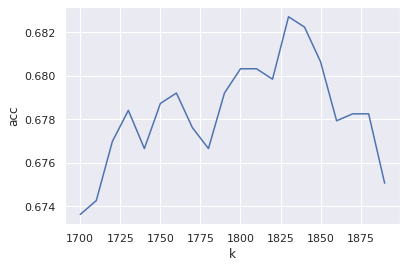

In [10]:
sns.lineplot(x='k', y='acc', data=df_opt_2)

El accuracy pra estos valores de $k$ resulta mayor que para el optimo 1. el mejor valor de $K$ hallado hasta ahora es $1830$ con $\mathrm{acc}_{k=1830}=0.683$.

       k       acc  time_predict
13  1830  0.682709      30.74872


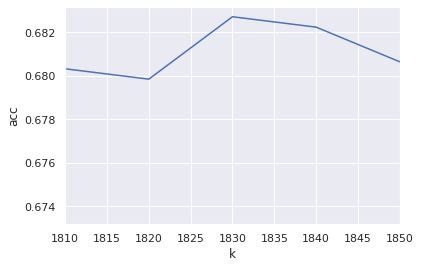

In [12]:
sns.lineplot(x='k', y='acc', data=df_opt_2)
plt.xlim(1810, 1850)

print(df_opt_2[df_opt_2['k'] == 1830])

Hago una busuqueda puntual:

In [16]:
df_opt_3 = lin_search(range(1820, 1836))

[DEBUG] Construyendo el kdtree
[DEBUG] Se construyó el kdtree en 0.738s
[DEBUG] Clasificando para k=1820...
[DEBUG] Se clasificó para k=1820 en 30.827s.
[DEBUG] Clasificando para k=1821...
[DEBUG] Se clasificó para k=1821 en 30.374s.
[DEBUG] Clasificando para k=1822...
[DEBUG] Se clasificó para k=1822 en 30.412s.
[DEBUG] Clasificando para k=1823...
[DEBUG] Se clasificó para k=1823 en 30.470s.
[DEBUG] Clasificando para k=1824...
[DEBUG] Se clasificó para k=1824 en 30.463s.
[DEBUG] Clasificando para k=1825...
[DEBUG] Se clasificó para k=1825 en 30.424s.
[DEBUG] Clasificando para k=1826...
[DEBUG] Se clasificó para k=1826 en 30.419s.
[DEBUG] Clasificando para k=1827...
[DEBUG] Se clasificó para k=1827 en 30.536s.
[DEBUG] Clasificando para k=1828...
[DEBUG] Se clasificó para k=1828 en 30.459s.
[DEBUG] Clasificando para k=1829...
[DEBUG] Se clasificó para k=1829 en 30.464s.
[DEBUG] Clasificando para k=1830...
[DEBUG] Se clasificó para k=1830 en 30.511s.
[DEBUG] Clasificando para k=1831...
[

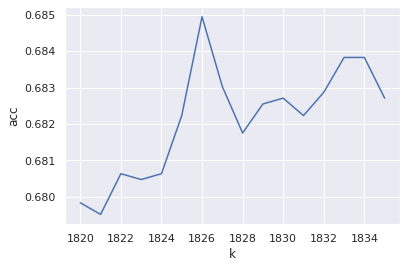

In [17]:
sns.lineplot(x='k', y='acc', data=df_opt_3)

In [19]:
def get_max_acc(df):
    '''
    Devuelve el máximo local para el accuracy en el rango `min_k <= k <= max_k`.
    '''
    id_opt = df['acc'].idxmax()
    return df.loc[id_opt]

print(get_max_acc(df_opt_3))

k               1826.000000
acc                0.684940
time_predict      30.419246
Name: 6, dtype: float64


## Consolidando

En esta parte junto los datos obtenidos en un dataframe. Genero el plot necesario para el informe y guardo los datos.

In [27]:
mediciones = pd.concat([df, df_opt_1, df_opt_2, df_opt_3])
mediciones.to_csv('results/opti-k-sin-pca.csv')

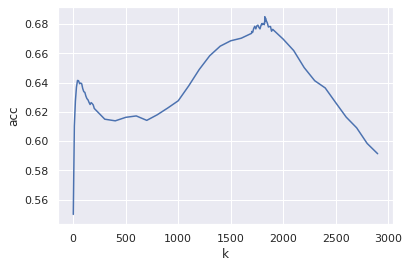

In [26]:
sns.lineplot(x='k', y='acc', data=mediciones)